In [1]:
# Modules

import constants as const
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
#import sciann as sn

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import statistics
from scipy.optimize import leastsq

In [2]:
# Import dataset using pandas

raw_dataset = pd.read_csv('../Dataset/Dataset_reduced.csv')
dataset = raw_dataset.copy()
print("Shape of dataset: "+str(dataset.shape))
dataset.tail()

Shape of dataset: (727292, 6)


,turbine,V,theta,W,T,P
727287,R80736,20.48,0.293564,1.801180,10817.3,2041980.0
727288,R80736,20.50,0.307352,1.799085,10837.3,2043120.0
727289,R80721,20.78,0.323933,1.799085,10850.1,2045870.0
727290,R80711,20.94,0.341386,1.799085,10853.8,2046570.0
727291,R80736,21.67,0.347670,1.798038,10871.8,2048260.0


In [3]:
# Clean dataset of NaN values
#dataset.isna().sum()
print(dataset.isna().sum())
dataset = dataset.dropna()

turbine    0
V          0
theta      0
W          0
T          0
P          0
dtype: int64


In [4]:
# One-hot encode categorical columns

dataset['turbine'] = dataset['turbine'].map({1:'R80711', 2:'R80721',3:'R80736', 4:'R80790'})
dataset = pd.get_dummies(dataset, columns=['turbine'], prefix='', prefix_sep='')
dataset.tail()

,V,theta,W,T,P
727287,20.48,0.293564,1.801180,10817.3,2041980.0
727288,20.50,0.307352,1.799085,10837.3,2043120.0
727289,20.78,0.323933,1.799085,10850.1,2045870.0
727290,20.94,0.341386,1.799085,10853.8,2046570.0
727291,21.67,0.347670,1.798038,10871.8,2048260.0


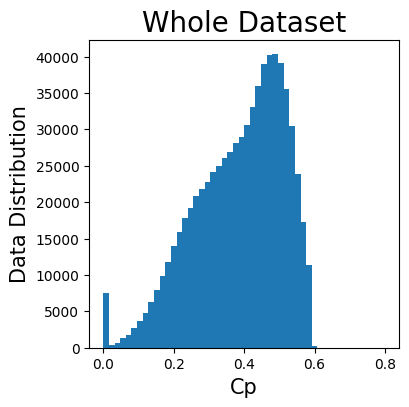

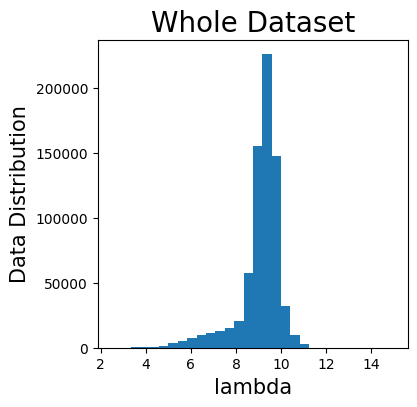

,V,theta,W,T,P,Cp,lambda
727287,20.48,0.293564,1.801180,10817.3,2041980.0,0.073492,3.605878
727288,20.50,0.307352,1.799085,10837.3,2043120.0,0.073318,3.598171
727289,20.78,0.323933,1.799085,10850.1,2045870.0,0.070489,3.549687
727290,20.94,0.341386,1.799085,10853.8,2046570.0,0.068909,3.522565
727291,21.67,0.347670,1.798038,10871.8,2048260.0,0.062228,3.401918


In [5]:
# Add Cp and lambda to the dataset

def Cp_fromP(Pturbina, Vw):

    Cp = Pturbina / (0.5 * const.rho * const.A * Vw**3)

    return Cp

def lambd(Vw, Wwt):

    lambd = Wwt * const.R / Vw

    return lambd

Cp_data = Cp_fromP(dataset['P'][:],dataset['V'][:])
dataset['Cp'] = Cp_data
lambd_data = lambd(dataset['V'][:], dataset['W'][:])
dataset['lambda'] = lambd_data

# Remove data with Cp>0.5926
#Cp_max = 0.5926
#dataset = dataset[ (dataset['Cp'] < Cp_max) ]

plt.figure(figsize=(4,4))
plt.hist(Cp_data, range=[0.0, 0.8], bins=50)
plt.xlabel('Cp',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Histogram of lambda
plt.figure(figsize=(4,4))
plt.hist(lambd_data, range=[2.5, 15], bins=30)
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

dataset.tail()

In [6]:
# Split the data into training and test sets

train_dataset = dataset.sample(frac=0.8, random_state=10)
test_dataset = dataset.drop(train_dataset.index)

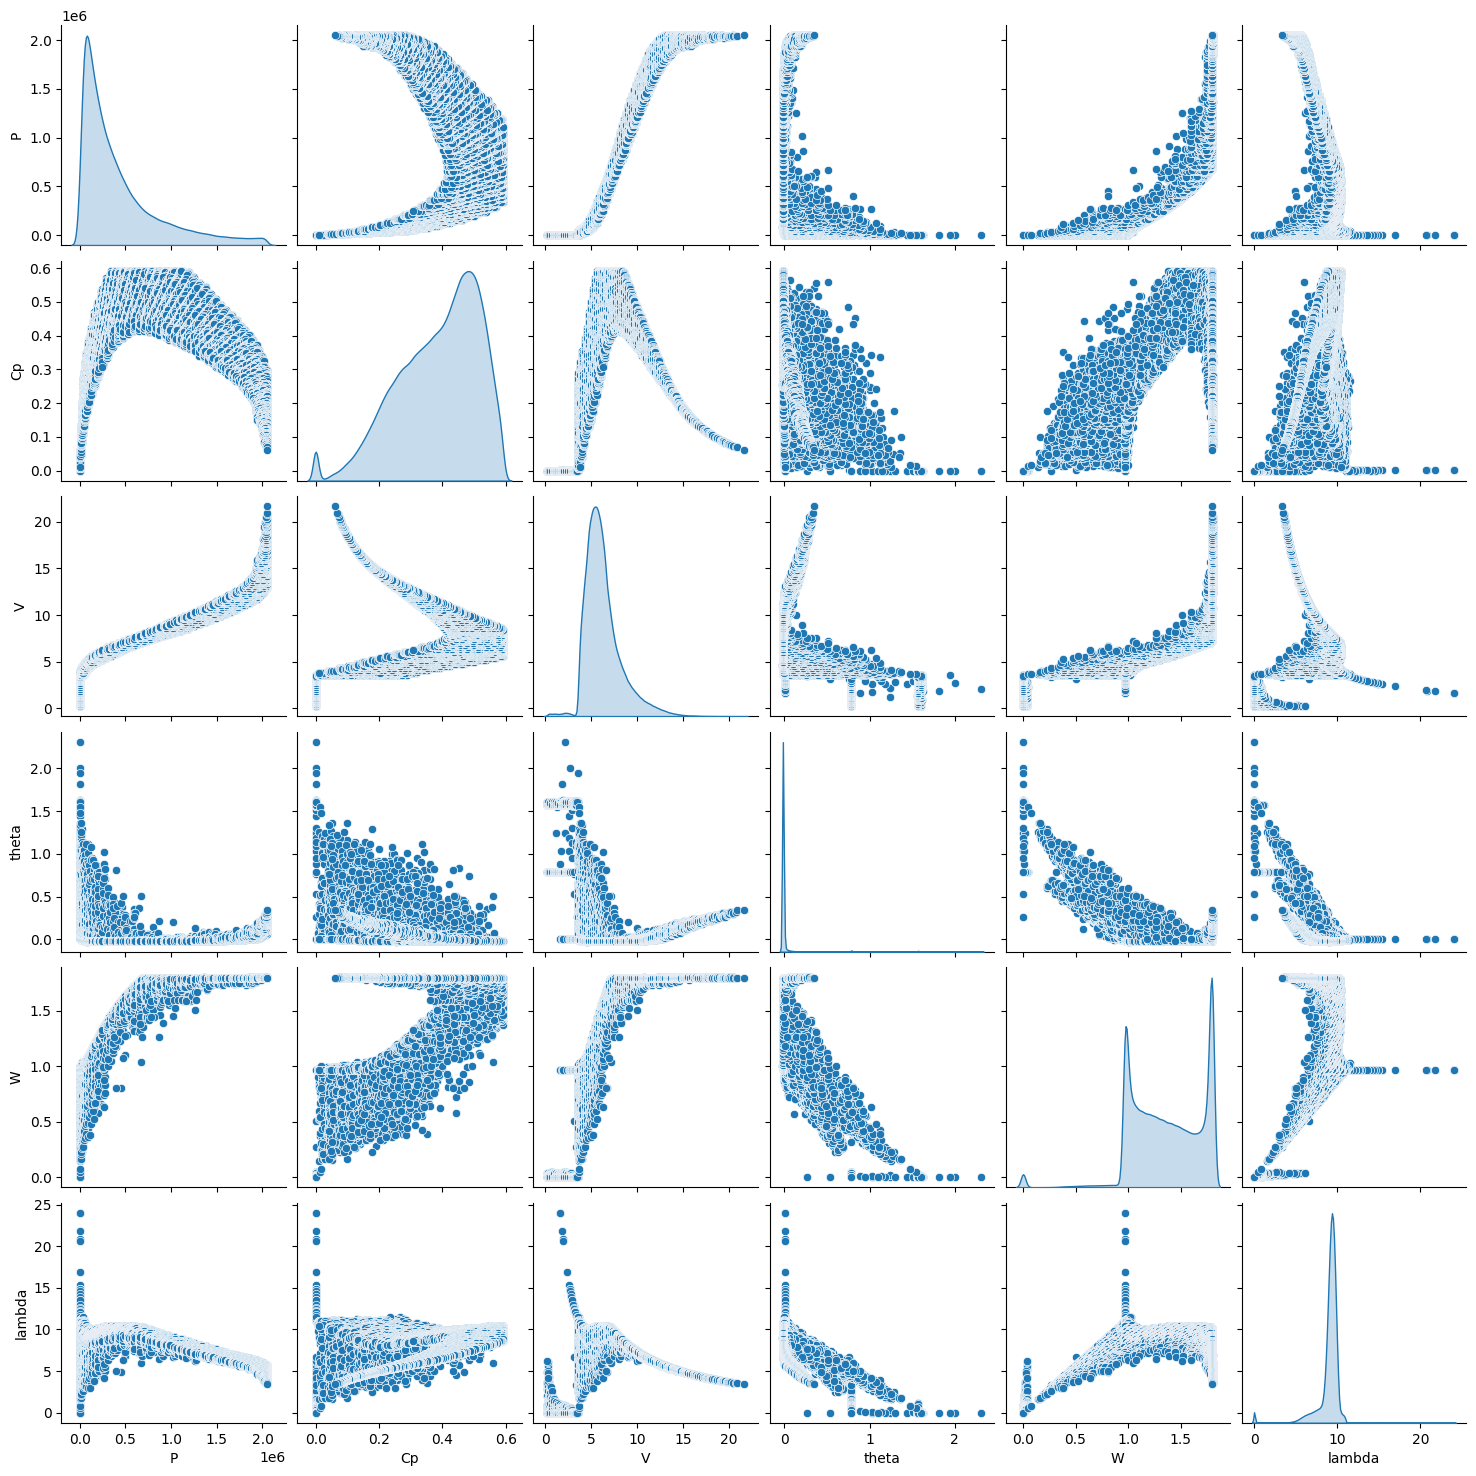

In [7]:
# Inspect the data with the joint distribition of a few pairs of columns from the training set

sns.pairplot(dataset[['P', 'Cp', 'V', 'theta', 'W', 'lambda']], diag_kind='kde')

In [7]:
# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
V,727292.0,6.281493,1.995660,0.230000,4.960000,5.870000,7.090000,2.167000e+01
theta,727292.0,0.002826,0.129452,-0.026704,-0.017453,-0.017279,-0.015708,2.312212e+00
W,727292.0,1.356542,0.329573,0.000000,1.089085,1.346696,1.660855,1.803274e+00
T,727292.0,2619.547843,2241.645819,0.000000,1043.010000,1963.324950,3376.169900,1.087570e+04
P,727292.0,439958.330594,442728.758322,0.000000,121400.000000,281620.000000,596549.992500,2.051870e+06
Cp,727292.0,0.385342,0.126188,0.000000,0.297588,0.407155,0.486534,5.925997e-01
lambda,727292.0,8.981742,1.298262,0.000000,8.852759,9.268851,9.602860,2.401763e+01


In [ ]:
""" # Normalization. 
# Cp in the range [0,1]. Originally, it was in [0,Cp_max]
# Rest of the variables with mean 0 and std 1

print(dataset.describe().transpose()[['mean', 'std']])

x_mean = np.nanmean( dataset, axis=0)
x_std = np.nanstd( dataset, axis=0 )

column_name = dataset.columns.values
Cp_column = column_name[5]
#print(Cp_column)

Cp_max = 0.5926
train_dataset_norm = train_dataset.copy()
test_dataset_norm = test_dataset.copy()
icol = 0
for col in column_name:
    if(col!='Cp'): # mean 0 and std 1
        train_dataset_norm[col]=(train_dataset[col]-x_mean[icol])/x_std[icol]
        test_dataset_norm[col]=(test_dataset[col]-x_mean[icol])/x_std[icol]
    else: # Cp in [0,1]
        train_dataset_norm[col]=train_dataset[col]/Cp_max
        test_dataset_norm[col]=test_dataset[col]/Cp_max
    icol = icol+1

print()
print("Normalized dataset")
print(train_dataset_norm.describe().transpose()[['mean', 'std']]) """

In [58]:
""" # theta offset to obtain positive angles

theta_data = dataset['theta']
theta_data = theta_data.to_numpy(dtype='float64')
#theta_offset = 1.5*min(theta_data)
theta_offset = min(theta_data)
print(theta_offset)
theta_offset = -theta_offset """

-0.0267035375555132


In [8]:
# Split input features from labels/targets

#train_dataset_copy = train_dataset_norm.copy()
#test_dataset_copy = test_dataset_norm.copy()
train_dataset_copy = train_dataset.copy()
test_dataset_copy = test_dataset.copy()

train_features = train_dataset_copy[['lambda','theta']]
test_features = test_dataset_copy[['lambda','theta']]
#train_features = train_dataset_copy[['V','theta','W']]
#test_features = test_dataset_copy[['V','theta','W']]

train_labels = train_dataset_copy.pop('Cp')
test_labels = test_dataset_copy.pop('Cp')

print(train_features.shape)
print(train_labels.shape)

(581834, 2)
(581834,)


In [9]:
# Define Cp data to fit

Cp_test = test_dataset['Cp']
theta_test = test_dataset['theta']
lambd_test = test_dataset['lambda']
Cp_test = Cp_test.to_numpy(dtype='float64')
lambd_test = lambd_test.to_numpy(dtype='float64')
theta_test = theta_test.to_numpy(dtype='float64')

Cp_train = train_dataset['Cp']
theta_train = train_dataset['theta']
lambd_train = train_dataset['lambda']
Cp_train = Cp_train.to_numpy(dtype='float64')
lambd_train = lambd_train.to_numpy(dtype='float64')
theta_train = theta_train.to_numpy(dtype='float64')

In [10]:
# Define the Cp formula

def Cp_formula( lambd, beta, params ):

    beta = beta * 180 / np.pi
    #beta = np.abs(beta)
    theta_offset = 2.5
    beta = beta + theta_offset

    # parameters
    params = np.array(params,dtype=float)
    c0 = params[0]
    c1 = params[1]
    c2 = params[2]
    c3 = params[3]
    c4 = params[4]
    c5 = params[5]
    c6 = params[6]
    c7 = params[7]
    d0 = params[8]
    d1 = params[9]
    d2 = params[10]

    gamma = 1/(lambd + d0*beta + d1) - d2/(1+beta**3)
    Cp = c0 *( c1*gamma - c2*beta - c3*beta**c4 - c5 ) *np.exp(-c6*gamma) + c7*lambd

    return Cp

In [11]:
# Fit parameters to the data with least squares

""" XX_data = np.zeros((len(lambd_data),2))
YY_data = np.zeros((len(Cp_data),1))

XX_data[:,0] = lambd_data[:]   # lambda
XX_data[:,1] = X_data[:,1]     # theta
YY_data[:,0] = Cp_data[:]      # Cp


XX_train, XX_test, YY_train, YY_test = train_test_split(XX_data, YY_data, test_size=0.2, random_state=38)
X_train, X_test, Y_train, Y_test = train_test_split(X_data,Y_data, test_size=0.2, random_state=38)

train_size = len(XX_train[:,0])
test_size = len(XX_test[:,0]) """

# Initial parameters

params0 = np.array([0.73, 151, 0.58, 0.002, 2.14, 13.2, 18.4, 0, 0.02, 0, 0.003], dtype=float)

# Fit parameters
def residuals( params, X, Y ):    
    return Y - Cp_formula(X[0], X[1], params[0:])

params_opt, flag = leastsq( residuals, params0, args=([lambd_train[:],theta_train[:]],Cp_train[:]),maxfev=1000000 )

print(params_opt)

/tmp/ipykernel_31295/3960307444.py:25: RuntimeWarning: overflow encountered in exp
  Cp = c0 *( c1*gamma - c2*beta - c3*beta**c4 - c5 ) *np.exp(-c6*gamma) + c7*lambd
/tmp/ipykernel_31295/3960307444.py:25: RuntimeWarning: overflow encountered in multiply
  Cp = c0 *( c1*gamma - c2*beta - c3*beta**c4 - c5 ) *np.exp(-c6*gamma) + c7*lambd


[ 7.63508081e-01  1.52875503e+02  4.86301299e-01  7.59396046e-04
  2.02650847e+00  1.29863176e+01  1.80908108e+01  2.22186824e-03
  9.47786024e-03 -1.67094607e-01 -7.28313436e-03]


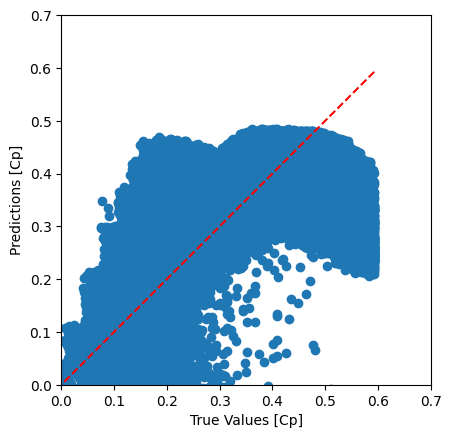


Test MAE: 0.11306602035295418
Test RMSE: 0.13898706815719267
Test MAPE: 37.65230018169577 %
Test R2: -0.2155624950125934


In [12]:
# Evaluate Cp fit on test data

# Pred vs True values

y_true = Cp_test
y_pred = Cp_formula( lambd_test[:], theta_test[:], params_opt)

y_true = y_true[~np.isnan(y_pred)]
y_pred = y_pred[~np.isnan(y_pred)]

a = plt.axes(aspect='equal')
p1 = max(max(y_pred), max(y_true))
p2 = min(min(y_pred), min(y_true))
plt.plot([p1, p2], [p1, p2], 'r--')
plt.scatter(y_true, y_pred)
plt.xlabel('True Values [Cp]')
plt.ylabel('Predictions [Cp]')
lims = [0, 0.7]
plt.xlim(lims)
plt.ylim(lims)
plt.show()
#_ = plt.plot(lims, lims)

y_pred_nonzero = y_pred[abs(y_true)>0]
y_true_nonzero = y_true[abs(y_true)>0]

test_mae = mean_absolute_error(y_true,y_pred)
test_rmse = mean_squared_error(y_true,y_pred,squared=False)
#test_mape = mean_absolute_percentage_error(y_true,y_pred)*100
test_mape = mean_absolute_percentage_error(y_true_nonzero,y_pred_nonzero)*100
test_r2 = r2_score(y_true,y_pred)

print()
print("Test MAE: "+str(test_mae))
print("Test RMSE: "+str(test_rmse))
print("Test MAPE: "+str(test_mape)+" %")
print("Test R2: "+str(test_r2))

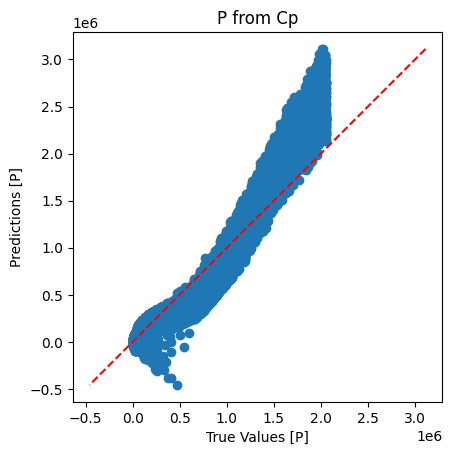


Test MAE: 113195.83725442197
Test RMSE: 167892.53289630997
Test MAPE: 37.65230018169577 %
Test R2: 0.8570317790424292


In [13]:
# Evaluate Cp on Power data

def P_fromCp(Cp, Vw):
    Pturbina = 0.5 * Cp * const.rho * const.A * Vw**3
    return Pturbina

# Pred vs True values

Cp_true = Cp_test
Cp_pred = Cp_formula( lambd_test[:], theta_test[:], params_opt)

#y_true = y_true[~np.isnan(y_pred)]
#y_pred = y_pred[~np.isnan(y_pred)]

V_true = test_dataset.loc[:,'V']
V_true = V_true.to_numpy()
P_true = test_dataset.loc[:,'P']
P_true = P_true.to_numpy()
P_pred = P_fromCp(Cp_pred,V_true)

y_true = P_true
y_pred = P_pred

# Plot
a = plt.axes(aspect='equal')
p1 = max(max(y_pred), max(y_true))
p2 = min(min(y_pred), min(y_true))
plt.plot([p1, p2], [p1, p2], 'r--')
plt.scatter(y_true, y_pred)
plt.xlabel('True Values [P]')
plt.ylabel('Predictions [P]')
plt.title('P from Cp')
plt.show()
#lims = [0, 50]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)

# Metrics
y_pred_nonzero = y_pred[abs(y_true)>0.0]
y_true_nonzero = y_true[abs(y_true)>0.0]

test_mae = mean_absolute_error(y_true,y_pred)
test_rmse = mean_squared_error(y_true,y_pred,squared=False)
#test_mape = mean_absolute_percentage_error(y_true,y_pred)*100
test_mape = mean_absolute_percentage_error(y_true_nonzero,y_pred_nonzero)*100
test_r2 = r2_score(y_true,y_pred)

print()
print("Test MAE: "+str(test_mae))
print("Test RMSE: "+str(test_rmse))
print("Test MAPE: "+str(test_mape)+" %")
print("Test R2: "+str(test_r2))

(727292,)
(727292,)


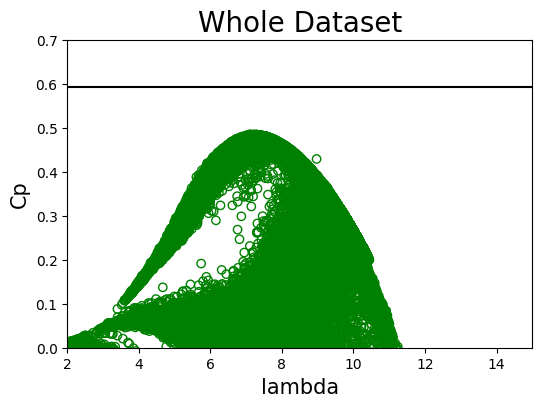

In [14]:
# Plot Cp vs lambda for all data

theta_data = dataset['theta']
theta_data = theta_data.to_numpy(dtype='float64')
lambd_data = dataset['lambda']
lambd_data = lambd_data.to_numpy(dtype='float64')

print(lambd_data.shape)
print(theta_data.shape)

Cp_predicted = Cp_formula(lambd_data[:], theta_data[:],params_opt)

# Plot Cp vs lambda of all data
Cp_max = 0.5926
plt.figure(figsize=(6,4))
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Cp',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
#plt.scatter(lambd_data, Cp_data,facecolors='none',edgecolors='blue')
plt.scatter(lambd_data,Cp_predicted, facecolors='none',edgecolors='green')
#plt.plot(lambd_data, Cp_predicted, 'go')
#plt.plot(lambd_predicted,Cp_data,'bo')
plt.axhline(y=Cp_max, color = 'k', linestyle = '-')
plt.xlim([2,15])
plt.ylim([0,0.7])
plt.show()

-0.017453292519943295
-0.013962634015954637
-0.010471975511965976
-0.006981317007977317
-0.0034906585039886583
0.0
0.0034906585039886622
0.00698131700797732
0.010471975511965978
0.013962634015954637
0.017453292519943295
0.020943951023931956
0.024434609527920616
0.027925268031909273
0.031415926535897934
0.03490658503988659
0.038397243543875255
0.04188790204786391
0.04537856055185257
0.048869219055841226


/tmp/ipykernel_31295/3960307444.py:25: RuntimeWarning: overflow encountered in exp
  Cp = c0 *( c1*gamma - c2*beta - c3*beta**c4 - c5 ) *np.exp(-c6*gamma) + c7*lambd


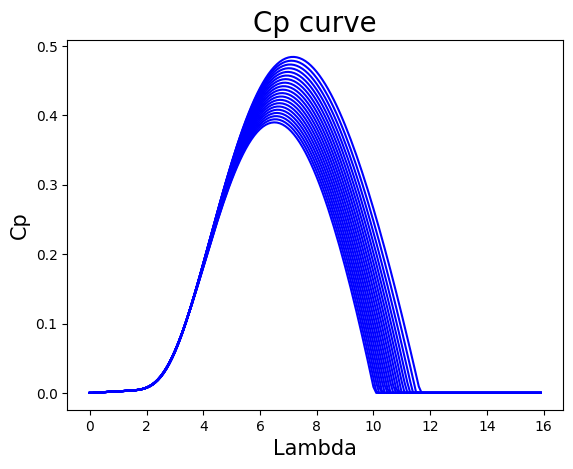

In [15]:
# Plot Cp vs lambda curve

lambd_plot = np.arange(0,16,0.1)
Cp_plot = np.zeros(len(lambd_plot))
pitch_angle = np.zeros(len(lambd_plot))

#pitch_angle[:] = -1.0 * np.pi/180.0
#pitch_angle[:] = -0.8 * np.pi/180.0
#pitch_angle[:] = -0.6 * np.pi/180.0
#pitch_angle[:] = -0.4 * np.pi/180.0
#pitch_angle[:] = -0.2 * np.pi/180.0
#pitch_angle[:] = 0.0 * np.pi/180.0
#pitch_angle[:] = 0.2 * np.pi/180.0
#pitch_angle[:] = 0.4 * np.pi/180.0
#pitch_angle[:] = 0.6 * np.pi/180.0
#pitch_angle[:] = 0.8 * np.pi/180.0

plt.figure()#figsize=(10,10))
dangle = 0.2
for i in range(20):
    angle = (-1.0 + i*dangle) * np.pi/180.0
    pitch_angle[:] = angle
    Cp_plot = Cp_formula(lambd_plot,pitch_angle,params_opt) 
    Cp_plot[ Cp_plot<0 ] = 0.0
    print(angle)
    plt.plot(lambd_plot, Cp_plot, 'b-')
    

#Cp_plot = Cp_formula(lambd_plot,pitch_angle,params_opt) 


#plt.figure()#figsize=(10,10))
#plt.plot(lambd_plot, Cp_plot, 'b-')
plt.xlabel('Lambda',fontsize=15)
plt.ylabel('Cp',fontsize=15)
#plt.axis('equal')
plt.title('Cp curve',fontsize=20)
plt.show()

In [16]:
import tensorflow as tf

# load NN_CP3D model 

model = tf.keras.models.load_model('./Models/Cp3D_constrained_model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               512       
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17,153
Trainable params: 17,153
Non-trainable params: 0
_________________________________________________________________


2023-05-05 18:51:55.867188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-05 18:51:55.897200: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-05-05 18:51:55.897244: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-05 18:51:55.898261: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

(727292, 1)
0.3848554
(727292,)
0.3853415261667347


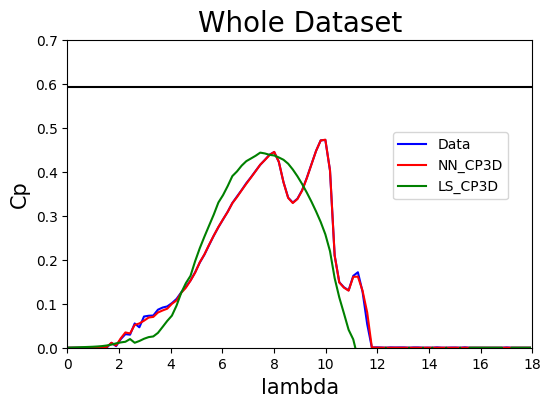

In [17]:
# Plot Cp vs lambda, averaging theta and W variable

# Prediction of Cp
x_norm = np.zeros((len(dataset['lambda']),3))
x_V = (dataset['V'] - dataset['V'].mean()) / dataset['V'].std()
x_theta = (dataset['theta'] - dataset['theta'].mean()) / dataset['theta'].std()
x_W = (dataset['W'] - dataset['W'].mean()) / dataset['W'].std()
x_norm[:,0] = x_V[:]
x_norm[:,1] = x_theta[:]
x_norm[:,2] = x_W[:]
Cp_norm = model.predict(x_norm)
#Cp_pred = Cp_norm * dataset['Cp'].std() + dataset['Cp'].mean()
Cp_pred = Cp_norm * Cp_max

# LS pred
Cp_pred_LS = Cp_formula( dataset['lambda'], dataset['theta'], params_opt )

# Estimate the Cp curve with the median
lmin = 0
lmax = 18
nbins = 100
Cp_estimated = np.zeros(nbins)
Cp_estimated_NN = np.zeros(nbins)
Cp_estimated_LS = np.zeros(nbins)
lambd_estimated = np.zeros(nbins)
dl = (lmax-lmin)/nbins

print(Cp_pred.shape)
print(np.mean(Cp_pred))
print(Cp_data.shape)
print(np.mean(Cp_data))

#Cp_predicted = np.zeros(nbins)

for i in range(1,nbins):
    lambdal = lmin + i*dl
    lambdar = lambdal + dl

    # Median of Cp in the bin i
    lambd_estimated[i] = (lambdal+lambdar)/2.0
    l_subset = (lambdal<lambd_data) & (lambd_data<lambdar)  # subset of lambda points of the bin
    Cpi = Cp_data[l_subset]     # Cp distribution of bin i
    Cpi_NN = Cp_pred[l_subset,0]  # Cp distribution of bin i
    Cpi_LS = Cp_pred_LS[l_subset]
    if (len(Cpi)>0):
        #Cp_estimated[i]=statistics.median(Cpi)
        Cp_estimated[i]=statistics.mean(Cpi)
        Cp_estimated_NN[i]=statistics.mean(Cpi_NN)
        Cp_estimated_LS[i]=statistics.mean(Cpi_LS)
        #Cp_estimated[i]=np.max(Cpi)
        #Cp_estimated[i]=np.percentile(Cpi,95)
    #else:
        #Cp_estimated[i]=Cp_estimated[i-1]


# Plot Cp vs lambda of all data
Cp_max = 0.5926
plt.figure(figsize=(6,4))
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Cp',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
#plt.scatter(lambd_data, Cp_data,facecolors='none',edgecolors='blue')
#plt.scatter(lambd_data,Cp_predicted, facecolors='none',edgecolors='green')
plt.plot(lambd_estimated, Cp_estimated, 'b-',label='Data')
plt.plot(lambd_estimated, Cp_estimated_NN, 'r-',label='NN_CP3D')
plt.plot(lambd_estimated, Cp_estimated_LS, 'g-',label='LS_CP3D')
#plt.plot(lambd_data, Cp_predicted, 'go')
#plt.plot(lambd_predicted,Cp_data,'bo')
plt.axhline(y=Cp_max, color = 'k', linestyle = '-')
plt.xlim([0,18])
plt.ylim([0,0.7])
l1 = plt.legend(bbox_to_anchor=(0.7, 0.7), borderaxespad=0)
plt.show()

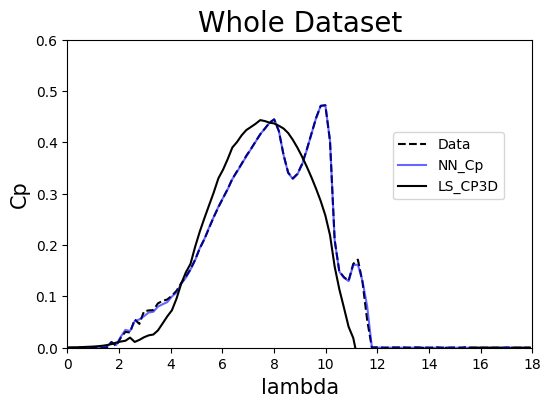

In [43]:
# Plot Cp vs lambda of all data
Cp_max = 0.5926
plt.figure(figsize=(6,4))
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Cp',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
#plt.scatter(lambd_data, Cp_data,facecolors='none',edgecolors='blue')
#plt.scatter(lambd_data,Cp_predicted, facecolors='none',edgecolors='green')
plt.plot(lambd_estimated, Cp_estimated, 'k--',label='Data')
plt.plot(lambd_estimated, Cp_estimated_NN, 'b-',alpha=0.6,label='NN_Cp')
plt.plot(lambd_estimated, Cp_estimated_LS, 'k-',label='LS_CP3D')
#plt.plot(lambd_data, Cp_predicted, 'go')
#plt.plot(lambd_predicted,Cp_data,'bo')
#plt.axhline(y=Cp_max, color = 'k', linestyle = '-')
plt.xlim([0,18])
plt.ylim([0,0.6])
l1 = plt.legend(bbox_to_anchor=(0.7, 0.7), borderaxespad=0)
plt.show()